##Emotional loyalty model demo

This notebook will walk you through a demo model implementing emotional loyalty scoring. The goal of this loyalty model is to account for the "emotional" engagement of the consumer with the service/product alongside with the transactional parameters like the frequency of purchases and purchase amount. 


Let's start by importing the libraries, loading the dataset and adding a random seed for reproducibility of the model.

In [1]:
!pip install -q opendatasets

In [22]:
# Import the necessary libraries
import os
import numpy as np
import pandas as pd
import opendatasets as od
import random
import re
import matplotlib.pyplot as plt

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [23]:
# Import the dataset
od.download("https://www.kaggle.com/datasets/bhadramohit/customer-shopping-latest-trends-dataset", data_dir="..")

Skipping, found downloaded files in "..\customer-shopping-latest-trends-dataset" (use force=True to force download)


In [24]:

csv_path = os.path.join("../customer-shopping-latest-trends-dataset", "shopping_trends.csv")
df = pd.read_csv(csv_path)

print(f"Loaded {len(df):,} rows and {df.shape[1]} columns.")
df.head()

Loaded 3,900 rows and 19 columns.


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


Now we want to get rid of the columns that do not give us any useful information (in real/larger datasets we would drop different columns, but for this demo we make the following choices).

In [25]:
# Check what columns we currently have
print(df.columns.tolist())

['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category', 'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season', 'Review Rating', 'Subscription Status', 'Payment Method', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Previous Purchases', 'Preferred Payment Method', 'Frequency of Purchases']


For the most columns it is clear why we do not want to include then, but let us explain the trickier ones. 'Category' and 'Season' in real data setting would be useful columns to examine, but due to this dataset being synthetic it only accounts for one purchase by each customer (i.e. even if a customer is said to be purchasing weekly, we will only have on of his purchases in the dataset).
- 'Category' could've been used to track engagement since we would expect loyal customers to be shopping across different categories.
- 'Season' in real data setting could be used to track whether the customer shops consistently throughout the year (signs of a loyal customer).

We also remove 'Promo Code Used' since it gives us the same information as 'Discount Applied' - those two columns are equal.

In [26]:
if df['Discount Applied'].equals(df['Promo Code Used']):
    print('Those columns are equal')
else:
    print('Those columns are different entries')

Those columns are equal


In [27]:
# Drop the columns that we will not use for the model
df = df.drop(columns= ['Item Purchased', 'Location', 'Size', 'Color', 'Shipping Type','Promo Code Used', 'Payment Method', 'Preferred Payment Method', 'Age', 'Gender', 'Category', 'Season'])

print(df.columns.tolist())

['Customer ID', 'Purchase Amount (USD)', 'Review Rating', 'Subscription Status', 'Discount Applied', 'Previous Purchases', 'Frequency of Purchases']


In [28]:
# Check how the dataset looks now
df.head()

,Customer ID,Purchase Amount (USD),Review Rating,Subscription Status,Discount Applied,Previous Purchases,Frequency of Purchases
0,1,53,3.1,Yes,Yes,14,Fortnightly
1,2,64,3.1,Yes,Yes,2,Fortnightly
2,3,73,3.1,Yes,Yes,23,Weekly
3,4,90,3.5,Yes,Yes,49,Weekly
4,5,49,2.7,Yes,Yes,31,Annually


Now we need to do more preprocessing by changing yes/no to 1/0; translating frequencies into floats; making sure the categorical values and the names of columns are consistent. 

In [29]:
# Write the columns with numerical and categorical entries out
Categorical = ['Subscription Status', 'Discount Applied', 'Frequency of Purchases']
Numerical = ['Customer ID','Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']

# Standardise the names
for cat in Categorical:
    vals = (df[cat].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True).str.lower().unique())
    sorted(vals)
    print(vals)


['yes' 'no']
['yes' 'no']
['fortnightly' 'weekly' 'annually' 'quarterly' 'bi-weekly' 'monthly'
 'every 3 months']


In [30]:
# Map yes/no to 0/1
def yn_to01(s):
    m = s.astype(str).str.strip().str.lower()
    return m.map({"yes":1,"no":0}).astype(float)

# Apply to the dataset
df['Subscription Status'] = yn_to01(df['Subscription Status'])
df['Discount Applied']    = yn_to01(df['Discount Applied'])

# Turn strings like 'Monthly' into events per year
freq_map = {
    "daily":365, "weekly":52, "fortnightly":26, "bi-weekly":26,
    "monthly":12, "every 3 months":4, "quarterly":4, "annually":1,
}
df["Frequency of Purchases"] = df["Frequency of Purchases"].astype(str).str.lower().map(freq_map).fillna(1.0)


In [31]:
# Check what we got
df.head()

,Customer ID,Purchase Amount (USD),Review Rating,Subscription Status,Discount Applied,Previous Purchases,Frequency of Purchases
0,1,53,3.1,1.0,1.0,14,26
1,2,64,3.1,1.0,1.0,2,26
2,3,73,3.1,1.0,1.0,23,52
3,4,90,3.5,1.0,1.0,49,52
4,5,49,2.7,1.0,1.0,31,1


In [32]:
# Make the column names consistent
def to_snake(name):
    name = re.sub(r"[^\w]+", "_", str(name).strip())
    name = re.sub(r"__+", "_", name)
    return name.strip("_").lower()

df.columns = [to_snake(c) for c in df.columns]
df.head()


,customer_id,purchase_amount_usd,review_rating,subscription_status,discount_applied,previous_purchases,frequency_of_purchases
0,1,53,3.1,1.0,1.0,14,26
1,2,64,3.1,1.0,1.0,2,26
2,3,73,3.1,1.0,1.0,23,52
3,4,90,3.5,1.0,1.0,49,52
4,5,49,2.7,1.0,1.0,31,1


Now we create blocks that represent emotional engagement, amount of money spent and the frequency of purchases. Those block will give each consumer a score based on their "performance" in each area. 

For this we need to create a normalisation function that will help us assign scores from 0 to 100 for each block for each consumer.

In [33]:
# Define a normalisation function
def norm_quantile_0_100(s, invert=False):
    x = pd.to_numeric(s, errors="coerce").to_numpy().reshape(-1,1)
    qt = QuantileTransformer(
        n_quantiles=min(1000, len(s)),
        output_distribution='uniform',
        random_state=42
    )
    y = (qt.fit_transform(x).ravel() * 100)
    return (100 - y) if invert else y


In [34]:
# Create a function that fills in missing values
def nz(s):
    return pd.to_numeric(s, errors="coerce").fillna(s.median())

# Create a copy of the dataset to not alter the original one
cust = df.copy()

# Make sure the numeric values are indeed numeric
for c in ["purchase_amount_usd","previous_purchases","frequency_of_purchases",
          "subscription_status","discount_applied",
          "review_rating","age"]:
    if c in cust.columns:
        cust[c] = pd.to_numeric(cust[c], errors="coerce")

# Since the data is synthetic, we only have one row per consumer, so we assume the last purchase is the average amount that they usually spend 
cust["freq_per_year"]   = cust["frequency_of_purchases"].fillna(1.0)
cust["total_spend_est"] = (cust["purchase_amount_usd"].fillna(0) * cust["freq_per_year"])
cust["avg_purchase"]    = cust["purchase_amount_usd"].fillna(0)

# Fill in the missing values for the engagement block 
cust["sub_rate"]     = cust["subscription_status"].fillna(0)
cust["discount_rate"] = cust["discount_applied"].fillna(0)     
cust["avg_rating"]    = cust["review_rating"].fillna(0)

# Now we bild the blocks with scores

# Spend/Value block is estimated by annual spend and average purchase
s_spend = np.nanmean(np.vstack([
    norm_quantile_0_100(nz(cust["total_spend_est"])),
    norm_quantile_0_100(nz(cust["avg_purchase"])),
]), axis=0)

# For engagement, we include sub + promos + rating (also add a cap so promo-chasers do not dominate)
s_engage = np.nanmean(np.vstack([
    norm_quantile_0_100(nz(cust["sub_rate"])),
    norm_quantile_0_100(nz(cust["discount_rate"])),
    norm_quantile_0_100(nz(cust["avg_rating"])),
]), axis=0)

# Assemble block scores
block_scores = pd.DataFrame({
    "customer_id": cust["customer_id"],
    "s_spend": s_spend,
    "s_engage": s_engage,
})

block_scores.head(200)



,customer_id,s_spend,s_engage
0,1,56.531532,74.574575
1,2,65.240240,74.574575
2,3,80.755756,74.574575
3,4,92.417417,80.063397
4,5,21.321321,69.235903
...,...,...,...
195,196,21.271271,90.857524
196,197,84.984985,85.251919
197,198,66.291291,75.892559
198,199,49.924925,97.397397


After the blocks that represent the parameters of interest in our model are made, we use them in unsupervised learning to find clusters of consumers that share similar behaviour with respect to those metrics.

Clustering on columns: ['s_engage', 's_spend']
K=4, silhouette(2D)=0.436


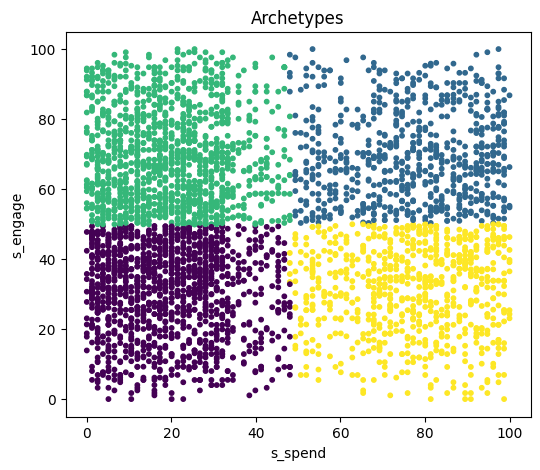

In [35]:
block_cols = sorted([c for c in block_scores.columns if c.startswith("s_")])
dims = len(block_cols)
print("Clustering on columns:", block_cols)

X  = block_scores[block_cols].values
Xs = StandardScaler().fit_transform(X)

# Perform the K-means clustering
best_k, best_sil, best_labels = None, -1, None
for k in range(3, 8):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(Xs)
    sil = silhouette_score(Xs, labels)
    if sil > best_sil:
        best_k, best_sil, best_labels = k, sil, labels

print(f"K={best_k}, silhouette({dims}D)={best_sil:.3f}")
block_scores["cluster"] = best_labels


plt.figure(figsize=(6,5))
plt.scatter(block_scores[block_cols[0]], block_scores[block_cols[1]], s=10, c=best_labels)
plt.title("Archetypes")
plt.xlabel("s_spend"); plt.ylabel("s_engage"); plt.show()

# Compute the unsupervised contribution, scale it and assigns a score based on the cluster to each consumer
row_eq = block_scores[['s_spend', 's_engage']].mean(axis=1)
cluster_base = row_eq.groupby(block_scores["cluster"]).mean()
cluster_ranks = cluster_base.rank(method='dense').astype(int) - 1
unsup = block_scores["cluster"].map(cluster_ranks)
unsup_scaled = (unsup / unsup.max()) * 100 if unsup.max() > 0 else 0
block_scores["unsup_signal"] = unsup_scaled


Based on the clustering above, we can assign to each of our customers one of 4 archetypes they belong to. Those will be:
- Brand Champions (high-spend high-engage) - loyal and spend a lot (the type of customers we want to reward the most).
- Transactional Spenders (high-spend low-engage) - Customers that spend a lot, but do not engage with the brand (the goal would be to offer them more appealing deals and offers to increase engagement) 
- Brand Advocates (low-spend high-engage) - highly loyal customers that do not spend enough (the customers we want to encourage to spend more)
- Passive Customers (low-spend low-engage) - passive customers that do not spend much, neither are loyal to the brand (the customers we want to reward the least).


In [36]:
# Calculate the average scores in each cluster
cluster_profiles = block_scores.groupby('cluster')[['s_spend', 's_engage']].mean().round(1)
print("\nCluster Profiles (Average Scores):")
print(cluster_profiles)

# Identify each archetype based on the cluster
low_score_cluster = cluster_profiles.sum(axis=1).idxmin()
high_score_cluster = cluster_profiles.sum(axis=1).idxmax()

# Identify the remaining two clusters
remaining_clusters = [c for c in cluster_profiles.index if c not in [low_score_cluster, high_score_cluster]]

# Sort the remaining clusters
if cluster_profiles.loc[remaining_clusters[0], 's_spend'] > cluster_profiles.loc[remaining_clusters[1], 's_spend']:
    transactional_cluster = remaining_clusters[0]
    advocate_cluster = remaining_clusters[1]
else:
    transactional_cluster = remaining_clusters[1]
    advocate_cluster = remaining_clusters[0]

# Create the mapping from cluster number to archetype
archetype_map = {
    high_score_cluster: 'Brand Champions',
    transactional_cluster: 'Transactional Spenders',
    advocate_cluster: 'Brand Advocates',
    low_score_cluster: 'Passive Customers'
}

print("\nAssigning the following map:")
print(archetype_map)

# Add the 'archetype' column to the DataFrame
block_scores['archetype'] = block_scores['cluster'].map(archetype_map)

block_scores.head()



Cluster Profiles (Average Scores):
         s_spend  s_engage
cluster                   
0           30.0      19.4
1           69.7      76.9
2           69.4      19.5
3           30.9      76.9

Assigning the following map:
{1: 'Brand Champions', 2: 'Transactional Spenders', 3: 'Brand Advocates', 0: 'Passive Customers'}


,customer_id,s_spend,s_engage,cluster,unsup_signal,archetype
0,1,56.531532,74.574575,1,100.000000,Brand Champions
1,2,65.240240,74.574575,1,100.000000,Brand Champions
2,3,80.755756,74.574575,1,100.000000,Brand Champions
3,4,92.417417,80.063397,1,100.000000,Brand Champions
4,5,21.321321,69.235903,3,66.666667,Brand Advocates


Next we move on to creating the function $U(x)$ that will be used in assigning the loyalty tiers. $U(x)$ is just a linear combination of contributions from each block scaled by the weights. We will be able to alter the contribution (weights) from each block (e.g. some companies care much a lot about how engaged consumers are, others not as much).

In [21]:
# Choose weights (they need to sum to 1)
knobs = {
    "spend":  0.40,
    "engage": 0.60,
}

# Keep only blocks that exist, then normalise
available = [c.replace("s_","") for c in block_scores.columns if c.startswith("s_")]
knobs = {k:v for k,v in knobs.items() if f"s_{k}" in block_scores.columns}
tot = sum(knobs.values()) or 1.0
knobs = {k: v/tot for k,v in knobs.items()}
print("Using knobs:", knobs)

# Define the function U(x)
def U_from_knobs(df, weights):
    u = np.zeros(len(df))
    for k,w in weights.items():
        u += w * df[f"s_{k}"].values
    return u

block_scores["U_seed"] = U_from_knobs(block_scores, knobs)


Using knobs: {'spend': 0.4, 'engage': 0.6}


Now we define the function $\text{tierer}(x) = \lambda * U(x) + (1-\lambda) * \text{unsup_contribution}$. This function will be assigning tiers to the consumer. It will account for both the contribution due to $U(x)$ that we tune using weights, and it will account for the contribution from the unsupervised learning (cluster contribution that does not depend on the weights). Parameter $\lambda$ will be our confidence in the model based on the weight that the business chose. 

We also add a multiplier based on the archetype of the customer, where we either increase the score (for example, for brand champions) or decrease the score (for passive consumers) 

In [18]:
# Create the multiplier and alter the boosts/penalties
archetype_multipliers = {
    'Brand Champions':        1.10,
    'Transactional Spenders': 0.95,
    'Brand Advocates':       1.15,
    'Passive Customers':      0.90
}

# Create a column with the multiplier for each customer
block_scores['multiplier'] = block_scores['archetype'].map(archetype_multipliers)

# Set our confidence parameter and create the tierer
LAMBDA = 0.7
base_score = LAMBDA*block_scores["U_seed"].values + (1-LAMBDA)*block_scores["unsup_signal"].values

# Apply the strategic multiplier
score = base_score * block_scores['multiplier'].values
block_scores["score"] = np.clip(score, 0, 100)

# Add the tier distribution (has to add to 1)
TARGET_MIX = {"Platinum":0.05, "Gold":0.15, "Silver":0.30, "Regular":0.50}

# Define the function that gives us tier cutoffs
def thresholds_from_mix(scores, mix):
    cum=0
    thr={}
    order=["Platinum","Gold","Silver","Regular"]
    for lvl in order[:-1]:
        thr[lvl] = np.quantile(scores, 1 - (cum + mix[lvl]))
        cum += mix[lvl]
    thr["Regular"] = -np.inf
    return thr

thr = thresholds_from_mix(block_scores["score"].values, TARGET_MIX)

# Function that assigns the tiers
def to_tier(s, thr):
    if s >= thr["Platinum"]: return "Platinum"
    if s >= thr["Gold"]:     return "Gold"
    if s >= thr["Silver"]:   return "Silver"
    return "Regular"

block_scores["tier"] = [to_tier(s, thr) for s in block_scores["score"].values]
print((block_scores["tier"].value_counts(normalize=True)*100).round(1))

tier
Regular     50.0
Silver      30.0
Gold        15.0
Platinum     5.0
Name: proportion, dtype: float64


Finally, let's see what tiers the function assigns to the customers! 

In [19]:
# Get the scores
tier_map  = block_scores.set_index("customer_id")["tier"]
score_map = block_scores.set_index("customer_id")["score"]
archetype = block_scores.set_index("customer_id")["archetype"]

# Add the scores to the dataset
view = df.copy()
view["tier"]  = view["customer_id"].map(tier_map)
view["score"] = view["customer_id"].map(score_map).round(1)
view["archetype"]  = view["customer_id"].map(archetype)

view.head(200)


,customer_id,purchase_amount_usd,review_rating,subscription_status,discount_applied,previous_purchases,frequency_of_purchases,tier,score,archetype
0,1,53,3.1,1.0,1.0,14,26,Gold,84.9,Brand Champions
1,2,64,3.1,1.0,1.0,2,26,Gold,87.5,Brand Champions
2,3,73,3.1,1.0,1.0,23,52,Gold,92.3,Brand Champions
3,4,90,3.5,1.0,1.0,49,52,Platinum,98.5,Brand Champions
4,5,49,2.7,1.0,1.0,31,1,Silver,63.3,Brand Advocates
...,...,...,...,...,...,...,...,...,...,...
195,196,25,4.3,1.0,1.0,34,12,Silver,73.7,Brand Advocates
196,197,88,3.9,1.0,1.0,41,26,Platinum,98.6,Brand Champions
197,198,78,3.2,1.0,1.0,41,12,Gold,88.5,Brand Champions
198,199,45,4.8,1.0,1.0,39,26,Gold,86.1,Brand Advocates


Looks like the tier distribution makes sense!

Now we just save the parameters of our model.

In [20]:
import json
config = {
    "knobs": knobs,                 
    "lambda": LAMBDA,               
    "K": int(block_scores["cluster"].nunique()),
    "thresholds": {k: float(v) for k,v in thr.items()} 
}
with open("../results/demo_config.json","w") as f:
    json.dump(config, f, indent=2)
print("Saved demo_config.json")


Saved demo_config.json
